
# Sistema de Recomendación de Cultivos con Deep Learning

Este sistema implementa un análisis comparativo de tres arquitecturas diferentes
de redes neuronales para la recomendación de cultivos basada en características
del suelo y condiciones climáticas.

Características principales:
- Preprocesamiento avanzado de datos con normalización
- Tres arquitecturas de modelos: DropClassifier, DeepDropoutClassifier, Conv1DClassifier
- Sistema de Early Stopping avanzado con múltiples criterios
- Comparación sistemática de modelos con métricas detalladas
- Motor de inferencia standalone para producción
- Visualizaciones y reportes automáticos

Autores: Alan Anthony Hernandez Perez y Luis Carlos Rico Almada.
Fecha: Mayo de 2025.

In [1]:
%pip install torch pandas numpy matplotlib seaborn scikit-learn tabulate

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Verificar dependencias principales
try:
    import sys
    print(f"🐍 Python ejecutable: {sys.executable}")
    print(f"📦 Versión de Python: {sys.version}")
    import os
    import torch
    import time
    import json
    import pickle
    from datetime import datetime
    from collections import deque
    from tabulate import tabulate
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.preprocessing import StandardScaler, LabelEncoder
    from torch.utils.data import Dataset
    import torch.nn.functional as F
    import torch.nn as nn
    from sklearn.metrics import classification_report, confusion_matrix, f1_score
    from torch.utils.data import random_split, DataLoader
    from typing import Union, List, Dict, Tuple, Optional
    import warnings
    print("✅ Todas las dependencias principales están disponibles")
except ImportError as e:
    print(f"❌ Error importando dependencias: {e}")
    print("💡 Instala las dependencias con: pip install torch pandas numpy matplotlib seaborn scikit-learn")

🐍 Python ejecutable: c:\Users\Sec. Tec. DGDH\AppData\Local\Programs\Python\Python310\python.exe
📦 Versión de Python: 3.10.10 (tags/v3.10.10:aad5f6a, Feb  7 2023, 17:20:36) [MSC v.1929 64 bit (AMD64)]
✅ Todas las dependencias principales están disponibles



## SECCIÓN 1: ANÁLISIS EXPLORATORIO Y PREPROCESAMIENTO DE DATOS


Esta sección se encarga de:
1. Cargar y explorar el dataset de recomendación de cultivos
2. Analizar la distribución de características por cultivo
3. Verificar la calidad y balance de los datos
4. Generar visualizaciones exploratorias

El dataset contiene 7 características numéricas:
- N, P, K: Contenido de nutrientes en el suelo (kg/ha)
- temperature: Temperatura promedio (°C)
- humidity: Humedad relativa (%)
- ph: Nivel de pH del suelo
- rainfall: Precipitación anual (mm)

Y una variable objetivo:
- label: Tipo de cultivo recomendado (22 clases diferentes)


In [3]:
# preprocesamiento

print(f"\n📊 ANÁLISIS EXPLORATORIO DE DATOS")
print(f"{'='*50}")

# Cargar dataset principal
try:
    df = pd.read_csv('Crop_recommendation.csv')
    print(f"✅ Dataset cargado exitosamente")
    print(f"📏 Dimensiones: {df.shape[0]} filas × {df.shape[1]} columnas")
    print(f"🏷️  Columnas: {list(df.columns)}")
except FileNotFoundError:
    print(f"❌ Error: No se encontró el archivo 'Crop_recommendation.csv'")
    print(f"💡 Asegúrate de que el archivo esté en el directorio actual")
    exit(1)

# Definir características numéricas y obtener cultivos únicos
cols = ["N", "P", "K", "temperature", "humidity", "ph", "rainfall"]
cultivos = df['label'].unique()

print(f"🌾 Cultivos únicos encontrados: {len(cultivos)}")
print(f"📊 Características a analizar: {cols}")


📊 ANÁLISIS EXPLORATORIO DE DATOS
✅ Dataset cargado exitosamente
📏 Dimensiones: 2200 filas × 8 columnas
🏷️  Columnas: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label']
🌾 Cultivos únicos encontrados: 22
📊 Características a analizar: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']


### VISUALIZACIÓN 1: HISTOGRAMAS POR CULTIVO Y CARACTERÍSTICA

Genera histogramas para cada característica agrupados por tipo de cultivo.
Esto permite identificar:
- Rangos típicos de cada característica para cada cultivo
- Distribuciones normales vs sesgadas
- Posibles outliers o valores atípicos
- Separabilidad entre cultivos

In [4]:
print(f"\n📈 Generando histogramas por cultivo...")

for col in cols:
    print(f"   📊 Procesando característica: {col}")

    n_cultivos = len(cultivos)
    ncols = 3  # Número de columnas en la grilla de subplots
    nrows = (n_cultivos + ncols - 1) // ncols  # Calcular filas necesarias

    # Crear figura con subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), squeeze=False)
    fig.suptitle(f'Distribución de {col} por Cultivo', fontsize=16, fontweight='bold')

    # Generar histograma para cada cultivo
    for i, cultivo in enumerate(cultivos):
        ax = axes[i // ncols, i % ncols]
        subset = df[df['label'] == cultivo]

        # Crear histograma con estilo mejorado
        sns.histplot(subset[col], bins=20, kde=False, color="skyblue",
                    alpha=0.7, ax=ax, stat='density')

        # Configurar subplot
        ax.set_title(f'Cultivo: {cultivo}', fontweight='bold')
        ax.set_xlabel(f'{col}')
        ax.set_ylabel('Densidad')
        ax.grid(True, alpha=0.3)

        # Agregar estadísticas básicas
        mean_val = subset[col].mean()
        std_val = subset[col].std()
        ax.axvline(mean_val, color='red', linestyle='--', alpha=0.7,
                  label=f'Media: {mean_val:.2f}')
        ax.legend(fontsize=8)

    # Eliminar subplots vacíos
    for j in range(i+1, nrows*ncols):
        fig.delaxes(axes[j // ncols, j % ncols])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    # plt.show()  # Descomentado para mostrar en entorno interactivo
    plt.close()  # Cerrar para ahorrar memoria


📈 Generando histogramas por cultivo...
   📊 Procesando característica: N
   📊 Procesando característica: P
   📊 Procesando característica: K
   📊 Procesando característica: temperature
   📊 Procesando característica: humidity
   📊 Procesando característica: ph
   📊 Procesando característica: rainfall


### VISUALIZACIÓN 2: BOXPLOTS PARA ANÁLISIS DE DISTRIBUCIONES Y OUTLIERS

Los boxplots permiten identificar:
- Medianas y cuartiles por cultivo
- Outliers (valores atípicos)
- Rango intercuartílico (IQR)
- Comparación visual entre cultivos

In [5]:
print(f"\n📦 Generando boxplots para análisis de outliers...")

for col in cols:
    print(f"   📊 Boxplot para: {col}")

    plt.figure(figsize=(16, 8))

    # Crear boxplot con estilo mejorado
    box_plot = sns.boxplot(x='label', y=col, data=df, palette='Set3')

    # Configurar gráfico
    plt.title(f'Distribución de {col} por Cultivo', fontsize=16, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Tipo de Cultivo', fontsize=12, fontweight='bold')
    plt.ylabel(f'{col}', fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3)

    # Agregar estadísticas globales
    global_mean = df[col].mean()
    global_median = df[col].median()
    plt.axhline(global_mean, color='red', linestyle='--', alpha=0.7,
               label=f'Media global: {global_mean:.2f}')
    plt.axhline(global_median, color='blue', linestyle='--', alpha=0.7,
               label=f'Mediana global: {global_median:.2f}')
    plt.legend()

    plt.tight_layout()
    # plt.show()  # Descomentado para mostrar en entorno interactivo
    plt.close()  # Cerrar para ahorrar memoria


📦 Generando boxplots para análisis de outliers...
   📊 Boxplot para: N
   📊 Boxplot para: P


C:\Users\Sec. Tec. DGDH\AppData\Local\Temp\ipykernel_26480\759716857.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(x='label', y=col, data=df, palette='Set3')
C:\Users\Sec. Tec. DGDH\AppData\Local\Temp\ipykernel_26480\759716857.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(x='label', y=col, data=df, palette='Set3')


   📊 Boxplot para: K
   📊 Boxplot para: temperature


C:\Users\Sec. Tec. DGDH\AppData\Local\Temp\ipykernel_26480\759716857.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(x='label', y=col, data=df, palette='Set3')
C:\Users\Sec. Tec. DGDH\AppData\Local\Temp\ipykernel_26480\759716857.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(x='label', y=col, data=df, palette='Set3')


   📊 Boxplot para: humidity
   📊 Boxplot para: ph


C:\Users\Sec. Tec. DGDH\AppData\Local\Temp\ipykernel_26480\759716857.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(x='label', y=col, data=df, palette='Set3')
C:\Users\Sec. Tec. DGDH\AppData\Local\Temp\ipykernel_26480\759716857.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(x='label', y=col, data=df, palette='Set3')


   📊 Boxplot para: rainfall


C:\Users\Sec. Tec. DGDH\AppData\Local\Temp\ipykernel_26480\759716857.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(x='label', y=col, data=df, palette='Set3')


### VERIFICACIÓN DE CALIDAD DE DATOS

Esta sección verifica:
1. Presencia de valores nulos o faltantes
2. Balance de clases en el dataset
3. Consistencia de los datos
4. Estadísticas descriptivas básicas

In [6]:
print(f"\n🔍 VERIFICACIÓN DE CALIDAD DE DATOS")
print(f"{'='*50}")

# 1. Verificar valores nulos
print(f"\n📋 Análisis de valores nulos:")
valores_nulos = df.isnull().sum()
print(valores_nulos)

if valores_nulos.sum() == 0:
    print("✅ No se encontraron valores nulos en el dataset")
else:
    print(f"⚠️ Se encontraron {valores_nulos.sum()} valores nulos")
    print("💡 Será necesario aplicar técnicas de imputación")

# 2. Verificar balance de clases
print(f"\n⚖️ Análisis de balance de clases:")
distribucion_cultivos = df['label'].value_counts().sort_index()
print(distribucion_cultivos)

# Calcular estadísticas de balance
min_samples = distribucion_cultivos.min()
max_samples = distribucion_cultivos.max()
mean_samples = distribucion_cultivos.mean()
std_samples = distribucion_cultivos.std()

print(f"\n📊 Estadísticas de distribución:")
print(f"   • Mínimo de muestras por clase: {min_samples}")
print(f"   • Máximo de muestras por clase: {max_samples}")
print(f"   • Promedio de muestras por clase: {mean_samples:.1f}")
print(f"   • Desviación estándar: {std_samples:.1f}")
print(f"   • Ratio max/min: {max_samples/min_samples:.2f}")

# Evaluar balance
if std_samples < mean_samples * 0.1:  # Menos del 10% de variación
    print("✅ Dataset bien balanceado")
elif std_samples < mean_samples * 0.2:  # Menos del 20% de variación
    print("⚠️ Dataset moderadamente balanceado")
else:
    print("❌ Dataset desbalanceado - considerar técnicas de balanceo")

# 3. Información general del dataset
print(f"\n📈 Información general del dataset:")
print(f"   • Total de muestras: {len(df):,}")
print(f"   • Número de características: {len(cols)}")
print(f"   • Número de clases (cultivos): {df['label'].nunique()}")
print(f"   • Cultivos disponibles: {sorted(df['label'].unique())}")

# 4. Estadísticas descriptivas
print(f"\n📊 Estadísticas descriptivas de características:")
estadisticas = df[cols].describe()
print(estadisticas.round(2))


🔍 VERIFICACIÓN DE CALIDAD DE DATOS

📋 Análisis de valores nulos:
N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64
✅ No se encontraron valores nulos en el dataset

⚖️ Análisis de balance de clases:
label
apple          100
banana         100
blackgram      100
chickpea       100
coconut        100
coffee         100
cotton         100
grapes         100
jute           100
kidneybeans    100
lentil         100
maize          100
mango          100
mothbeans      100
mungbean       100
muskmelon      100
orange         100
papaya         100
pigeonpeas     100
pomegranate    100
rice           100
watermelon     100
Name: count, dtype: int64

📊 Estadísticas de distribución:
   • Mínimo de muestras por clase: 100
   • Máximo de muestras por clase: 100
   • Promedio de muestras por clase: 100.0
   • Desviación estándar: 0.0
   • Ratio max/min: 1.00
✅ Dataset bien balanceado

📈 Información ge

In [7]:
class CropDataset(Dataset):
    def __init__(self, csv_path, export_path=None):
        df = pd.read_csv(csv_path)

        self.feature_columns = df.columns[:-1]
        self.label_column = df.columns[-1]

        # Codificar etiquetas a números

        unique_labels = df[self.label_column].unique()
        self.label_mapping = {label: idx for idx, label in enumerate(unique_labels)}

        #generacion de la columna de label encoded
        df['encoded_label'] = df[self.label_column].map(self.label_mapping)

        for crop, idx in self.label_mapping.items():
            print(f"Label: {crop}, Encoded: {idx}")

        # Normalización global
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(df[self.feature_columns])
        normalized_df = pd.DataFrame(scaled_features, columns=self.feature_columns)
        normalized_df['label'] = df[self.label_column]
        normalized_df['encoded_label'] = df['encoded_label']

        # Mezclar datos (shuffle)
        normalized_df = normalized_df.sample(frac=1).reset_index(drop=True)

        # Guardar CSV si se especifica ruta
        if export_path:
            normalized_df.to_csv(export_path, index=False)
            print(f"[INFO] CSV exportado en: {export_path}")

        # Convertir a tensores
        self.X = torch.tensor(normalized_df[self.feature_columns].values, dtype=torch.float32)
        self.y = torch.tensor(normalized_df['encoded_label'].values, dtype=torch.long)

        self.num_classes = len(unique_labels)


    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    def get_x_y(self):
        return self.X, self.y

    def get_label_mapping(self):
        return self.label_mapping

In [8]:
dataset = CropDataset("Crop_recommendation.csv", export_path="Crop_recommendation_normalized.csv")

Label: rice, Encoded: 0
Label: maize, Encoded: 1
Label: chickpea, Encoded: 2
Label: kidneybeans, Encoded: 3
Label: pigeonpeas, Encoded: 4
Label: mothbeans, Encoded: 5
Label: mungbean, Encoded: 6
Label: blackgram, Encoded: 7
Label: lentil, Encoded: 8
Label: pomegranate, Encoded: 9
Label: banana, Encoded: 10
Label: mango, Encoded: 11
Label: grapes, Encoded: 12
Label: watermelon, Encoded: 13
Label: muskmelon, Encoded: 14
Label: apple, Encoded: 15
Label: orange, Encoded: 16
Label: papaya, Encoded: 17
Label: coconut, Encoded: 18
Label: cotton, Encoded: 19
Label: jute, Encoded: 20
Label: coffee, Encoded: 21
[INFO] CSV exportado en: Crop_recommendation_normalized.csv


In [9]:
X, y = dataset[0]
print("Features (X):", X)
print("Etiqueta y", y)
print("Forma de y:", y.shape)

Features (X): tensor([ 1.9087, -0.0110, -0.5757, -0.4154,  0.2356,  1.9482, -0.4250])
Etiqueta y tensor(19)
Forma de y: torch.Size([])


In [32]:
def earlyStopping(val_losses, best_moving_avg_loss,
                  patience, epochs_without_improvement, window_size,
                  model, model_name, delta=1e-4):
    """
    Early Stopping con detección de plateau basado en media móvil de val_loss.

    Args:
        delta (float): mejora mínima requerida para considerar que hay progreso.
    """
    stop = False
    if len(val_losses) >= window_size:
        moving_avg = sum(val_losses[-window_size:]) / window_size
        print("Media móvil del loss de validación:", moving_avg)

        if best_moving_avg_loss - moving_avg > delta:
            best_moving_avg_loss = moving_avg
            epochs_without_improvement = 0
            torch.save(model.state_dict(), f'best_{model_name}.pth')
            print("Nueva mejor media móvil. Modelo guardado.")
        else:
            epochs_without_improvement += 1
            print("No hubo mejora significativa en el loss de validación.")
            print("Épocas sin mejora:", epochs_without_improvement, "de", patience)
            if epochs_without_improvement >= patience:
                print("Detención temprana activada por plateau.")
                stop = True

    return stop, best_moving_avg_loss, epochs_without_improvement


In [33]:
def train_model(model, model_name, train_loader, val_loader, device, num_epochs=1000, lr=0.001, window_size=10, patience=10):
    """
    Función para entrenar un modelo con early stopping avanzado
    """
    print(f"\n{'='*50}")
    print(f"Entrenando modelo: {model_name}")
    print(f"{'='*50}")

    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

   
    # parametros para Early Stopping
    train_losses = []#listas para graficacion
    val_losses = []



    # Parámetros de Early Stopping
    epochs_without_improvement = 0
    best_moving_avg_loss = float('inf')
    best_epoch = 0

    #primero enta en modo de entrenamiento por cada epoca con su reponsable batch
    for epoch in range(num_epochs):
        losses = []

        for train_batch in train_loader:
            x, y = train_batch
            if torch.cuda.is_available():
                x = x.cuda(0)
                y = y.cuda(0)

            y_hat = model(x)
            loss = nn.functional.cross_entropy(y_hat, y)
            losses.append(loss.item())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()


        losses = torch.mean(torch.tensor(losses))
        train_losses.append(losses.item())
        

        # Validación cada epoch para asi determinar si esta mejorando nuestro modelo o si esta overfitting
        model.eval()
        with torch.no_grad():
            val_loss = []

            for val_batch in val_loader:
                x, y = val_batch
                if torch.cuda.is_available():
                    x = x.cuda(0)
                    y = y.cuda(0)

                y_hat = model(x)
                loss = nn.functional.cross_entropy(y_hat, y)
                val_loss.append(loss.item())

            val_loss = torch.mean(torch.tensor(val_loss))
            val_losses.append(val_loss.item())
        

            print(f"Epoca {epoch + 1}/{num_epochs} : Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}")



            # Verificación de early stopping
            stop, best_moving_avg_loss, epochs_without_improvement = earlyStopping(
                val_losses, best_moving_avg_loss,
                patience, epochs_without_improvement, window_size, model, model_name, delta=1e-4
            )
            if stop:
                best_epoch = epoch - epochs_without_improvement
                break

        model.train()

    if len(val_losses) > best_epoch:
        #quitamos las epocas que no nos importan
        val_losses = val_losses[:best_epoch + 1]
        train_losses = train_losses[:best_epoch + 1]

    print("Best epoch:", best_epoch)

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss per Epoch")
    plt.legend()
    plt.grid(True)
    plt.show()

    

    return None

In [12]:
def evaluate_model(model, val_loader, n_classes):
    """
    Función para evaluar un modelo y calcular métricas
    """
    model.eval()
    matriz_confusion = np.zeros((n_classes, n_classes))

    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            if torch.cuda.is_available():
                x_batch = x_batch.cuda(0)
                y_batch = y_batch.cuda(0)
            y_pred = model(x_batch)
            preds = torch.argmax(y_pred, dim=1)
            for t, p in zip(y_batch.view(-1), preds.view(-1)):
                matriz_confusion[t.long(), p.long()] += 1

    # Calcular métricas por clase
    precision = []
    recall = []
    f1_score = []
    accuracy_por_clase = []

    for i in range(n_classes):
        TP = matriz_confusion[i, i]
        FP = matriz_confusion[:, i].sum() - TP
        FN = matriz_confusion[i, :].sum() - TP
        TN = matriz_confusion.sum() - (TP + FP + FN)

        precision_i = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall_i = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1_score_i = 2 * ((precision_i * recall_i) / (precision_i + recall_i)) if (precision_i + recall_i) > 0 else 0
        accuracy_i = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0

        precision.append(precision_i)
        recall.append(recall_i)
        f1_score.append(f1_score_i)
        accuracy_por_clase.append(accuracy_i)

    # Métricas globales
    precision_global = np.mean(precision)
    recall_global = np.mean(recall)
    f1_score_global = 2 * (precision_global * recall_global) / (precision_global + recall_global) if (precision_global + recall_global) > 0 else 0
    accuracy_global = np.mean(accuracy_por_clase)

    label_mapping = dataset.get_label_mapping()

    inverse_label_mapping = {v: k for k, v in label_mapping.items()}
    classes = [inverse_label_mapping[i] for i in range(n_classes)]

    # Imprimir métricas
    df = pd.DataFrame({
        'Cultivo': classes,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score,
        'Accuracy': accuracy_por_clase
    })
    df.loc["Globales"] = ["—", precision_global, recall_global, f1_score_global, accuracy_global]

    return df, matriz_confusion

In [13]:
def predict_crop_with_device(model, features, label_mapping, device):
    """
    Función para hacer predicciones con un modelo entrenado

    Args:
        model: modelo entrenado
        features: tensor con las características [N, P, K, temperature, humidity, ph, rainfall]
        label_mapping: diccionario de mapeo de etiquetas
        device: dispositivo (CPU/GPU)

    Returns:
        predicted_crop: nombre del cultivo predicho
        probabilities: probabilidades para cada clase
    """
    model.eval()
    inverse_label_mapping = {v: k for k, v in label_mapping.items()}

    with torch.no_grad():
        if isinstance(features, list):
            features = torch.tensor(features, dtype=torch.float32)

        if len(features.shape) == 1:
            features = features.unsqueeze(0)  # Agregar dimensión de batch

        features = features.to(device)

        # Hacer predicción
        outputs = model(features)
        probabilities = F.softmax(outputs, dim=1)
        predicted_class = torch.argmax(outputs, dim=1)

        predicted_crop = inverse_label_mapping[predicted_class.item()]

        return predicted_crop, probabilities.cpu().numpy()[0]

In [14]:
#Generacion de los modelos

class DropClassifier(torch.nn.Module):

    def __init__(self, n_classes, input_size=7, hidden_size=64):
      super(DropClassifier, self).__init__()

      self.encoder = nn.Sequential(
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, n_classes)
      )


    def forward(self, x):
        x = x.view(x.size(0), -1)
        y_hat = self.encoder(x)
        return y_hat

In [15]:
class DeepDropoutClassifier(torch.nn.Module):
    """
    Modelo 2: Red neuronal más profunda con Dropout y Batch Normalization
    """
    def __init__(self, n_classes, input_size=7, hidden_sizes=[128, 256, 128, 64], dropout_rate=0.3):
        super(DeepDropoutClassifier, self).__init__()

        layers = []
        prev_size = input_size

        for i, hidden_size in enumerate(hidden_sizes):
            # Capa lineal
            layers.append(nn.Linear(prev_size, hidden_size))
            # Batch normalization
            layers.append(nn.BatchNorm1d(hidden_size))
            # Activación
            layers.append(nn.ReLU())
            # Dropout
            layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size

        # Capa de salida
        layers.append(nn.Linear(prev_size, n_classes))

        self.encoder = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        y_hat = self.encoder(x)
        return y_hat

In [16]:
class Conv1DClassifier(torch.nn.Module):
    """
    Modelo 3: Red neuronal con capas convolucionales 1D
    """
    def __init__(self, n_classes, input_size=7, conv_channels=[16, 32, 64], kernel_size=3):
        super(Conv1DClassifier, self).__init__()

        # Capas convolucionales 1D
        conv_layers = []
        in_channels = 1

        for out_channels in conv_channels:
            conv_layers.extend([
                nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2),
                nn.BatchNorm1d(out_channels),
                nn.ReLU(),
                nn.Dropout(0.2)
            ])
            in_channels = out_channels

        self.conv_layers = nn.Sequential(*conv_layers)

        # Calcular el tamaño después de las convoluciones
        # Para input_size=7 y padding='same', el tamaño se mantiene
        conv_output_size = input_size * conv_channels[-1]

        # Capas fully connected
        self.fc_layers = nn.Sequential(
            nn.Linear(conv_output_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, n_classes)
        )

        # Global Average Pooling como alternativa
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc_alternative = nn.Sequential(
            nn.Linear(conv_channels[-1], 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        batch_size = x.size(0)
        # Reshape para conv1d: (batch_size, channels, sequence_length)
        x = x.view(batch_size, 1, -1)

        # Aplicar capas convolucionales
        x = self.conv_layers(x)

        # Opción 1: Flatten y FC layers
        # x = x.view(batch_size, -1)
        # y_hat = self.fc_layers(x)

        # Opción 2: Global Average Pooling (más eficiente)
        x = self.global_avg_pool(x)  # (batch_size, channels, 1)
        x = x.view(batch_size, -1)   # (batch_size, channels)
        y_hat = self.fc_alternative(x)

        return y_hat

### Módulo de Comparación 

Este módulo proporciona herramientas para comparar múltiples arquitecturas de modelos
de deep learning, incluyendo análisis de rendimiento, overfitting, tiempo de convergencia
y recomendaciones finales.

In [ ]:

def train_multiple_models(model_list, train_loader, val_loader, device,
                          num_epochs=1000, lr=0.001, window_size=10, patience=10):
    """
    Entrena múltiples modelos y muestra cuánto tiempo toma cada entrenamiento.

    Args:
        model_list (list): lista de tuplas (modelo, nombre)
    """


    for model, model_name in model_list:
        print(f"\n Entrenando modelo: {model_name}")
        
        start_time = time.time()
        model.to(device)
        
        
        train_model(
            model=model,
            model_name=model_name,
            train_loader=train_loader,
            val_loader=val_loader,
            device=device,
            num_epochs=num_epochs,
            lr=lr,
            window_size=window_size,
            patience=patience
        )
        
        end_time = time.time()
        elapsed = end_time - start_time
        print(f" Tiempo de entrenamiento para {model_name}: {elapsed:.2f} segundos")
        print(f" Entrenamiento de {model_name} finalizado.\n" + "-"*40)

    #copnseguir las metricas de cada modelo
    for model, model_name in model_list:
        df, matriz_confusion = evaluate_model(model, val_loader, dataset.num_classes)
        print(f"\n Métricas para el modelo {model_name}:")
        print(tabulate(df, headers='keys', tablefmt='pretty', floatfmt=".2f"))
        #graficar la matriz de confusión como mapa de calor
        print(f"\n Matriz de confusión para el modelo {model_name}:")
        plt.figure(figsize=(10, 8))
        sns.heatmap(matriz_confusion, annot=True, fmt=".0f", cmap='Blues',
                   xticklabels=df['Cultivo'], yticklabels=df['Cultivo'])
        plt.title(f"Matriz de Confusión para el modelo {model_name}")
        plt.xlabel("Predicción")
        plt.ylabel("Real")
        plt.show()
        
        


In [27]:
x, y = dataset.get_x_y()
#dataset reunido

dataset_tratado = torch.utils.data.TensorDataset(x, y)

# Dividir el dataset en entrenamiento y prueba
#70% entrenamiento, 30% prueba
train, val = random_split(dataset_tratado, [int(len(dataset_tratado) * 0.6), int(len(dataset_tratado) * 0.4)])
#genera los dataloaders
#ademas de aplicar el shuffle, para utilizar el teorema de limite central
train = DataLoader(train, batch_size=32, shuffle=True)
val= DataLoader(val, batch_size=32, shuffle=True)

Dispositivo utilizado: cuda

 Entrenando modelo: DropClassifier

Entrenando modelo: DropClassifier
Epoca 1/1000 : Train Loss: 2.9011, Validation Loss: 2.6308
Epoca 2/1000 : Train Loss: 2.1910, Validation Loss: 1.7674
Epoca 3/1000 : Train Loss: 1.3483, Validation Loss: 1.0434
Epoca 4/1000 : Train Loss: 0.8056, Validation Loss: 0.6720
Epoca 5/1000 : Train Loss: 0.5580, Validation Loss: 0.5073
Epoca 6/1000 : Train Loss: 0.4195, Validation Loss: 0.4009
Epoca 7/1000 : Train Loss: 0.3290, Validation Loss: 0.3354
Epoca 8/1000 : Train Loss: 0.2725, Validation Loss: 0.2821
Epoca 9/1000 : Train Loss: 0.2282, Validation Loss: 0.2406
Epoca 10/1000 : Train Loss: 0.2021, Validation Loss: 0.2086
Media móvil del loss de validación: 0.8088460102677345
Nueva mejor media móvil. Modelo guardado.
Epoca 11/1000 : Train Loss: 0.1743, Validation Loss: 0.1878
Media móvil del loss de validación: 0.5645477294921875
Nueva mejor media móvil. Modelo guardado.
Epoca 12/1000 : Train Loss: 0.1516, Validation Loss: 0.1

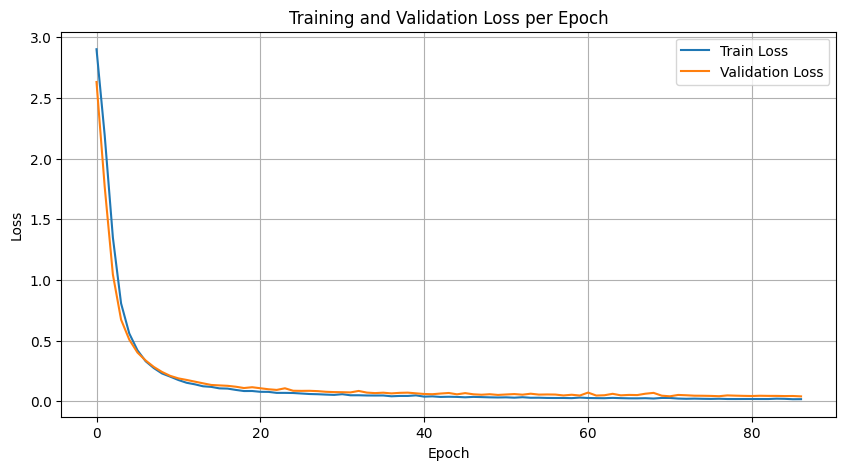

 Tiempo de entrenamiento para DropClassifier: 7.04 segundos
 Entrenamiento de DropClassifier finalizado.
----------------------------------------

 Entrenando modelo: DeepDropoutClassifier

Entrenando modelo: DeepDropoutClassifier
Epoca 1/1000 : Train Loss: 2.6224, Validation Loss: 2.0326
Epoca 2/1000 : Train Loss: 1.9871, Validation Loss: 1.4635
Epoca 3/1000 : Train Loss: 1.5716, Validation Loss: 1.0858
Epoca 4/1000 : Train Loss: 1.3005, Validation Loss: 0.7905
Epoca 5/1000 : Train Loss: 1.0619, Validation Loss: 0.5838
Epoca 6/1000 : Train Loss: 0.9469, Validation Loss: 0.4513
Epoca 7/1000 : Train Loss: 0.7989, Validation Loss: 0.3519
Epoca 8/1000 : Train Loss: 0.7103, Validation Loss: 0.2886
Epoca 9/1000 : Train Loss: 0.6163, Validation Loss: 0.2305
Epoca 10/1000 : Train Loss: 0.5887, Validation Loss: 0.2154
Media móvil del loss de validación: 0.7493821397423744
Nueva mejor media móvil. Modelo guardado.
Epoca 11/1000 : Train Loss: 0.5228, Validation Loss: 0.1637
Media móvil del loss 

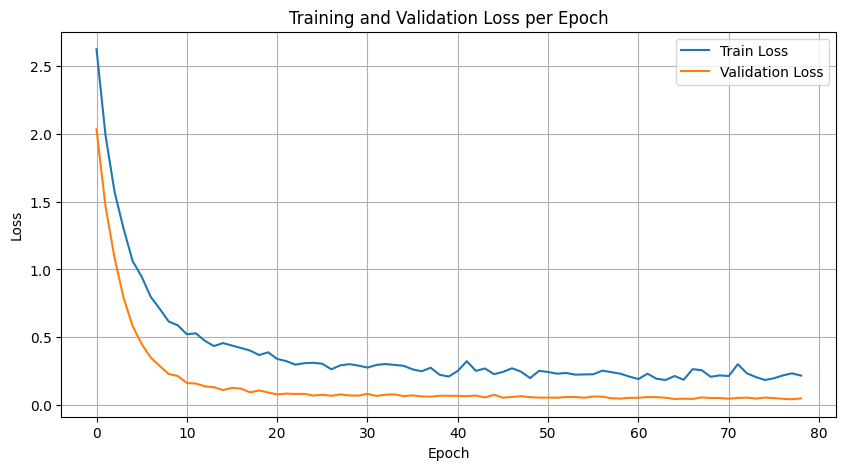

 Tiempo de entrenamiento para DeepDropoutClassifier: 11.33 segundos
 Entrenamiento de DeepDropoutClassifier finalizado.
----------------------------------------

 Métricas para el modelo DropClassifier:
+----------+-------------+--------------------+--------------------+--------------------+--------------------+
|          |   Cultivo   |     Precision      |       Recall       |      F1 Score      |      Accuracy      |
+----------+-------------+--------------------+--------------------+--------------------+--------------------+
|    0     |    rice     | 0.9393939393939394 | 0.9117647058823529 | 0.9253731343283583 | 0.9943181818181818 |
|    1     |    maize    |        1.0         |        1.0         |        1.0         |        1.0         |
|    2     |  chickpea   |        1.0         |        1.0         |        1.0         |        1.0         |
|    3     | kidneybeans | 0.9512195121951219 |        1.0         |       0.975        | 0.9977272727272727 |
|    4     | pigeonp

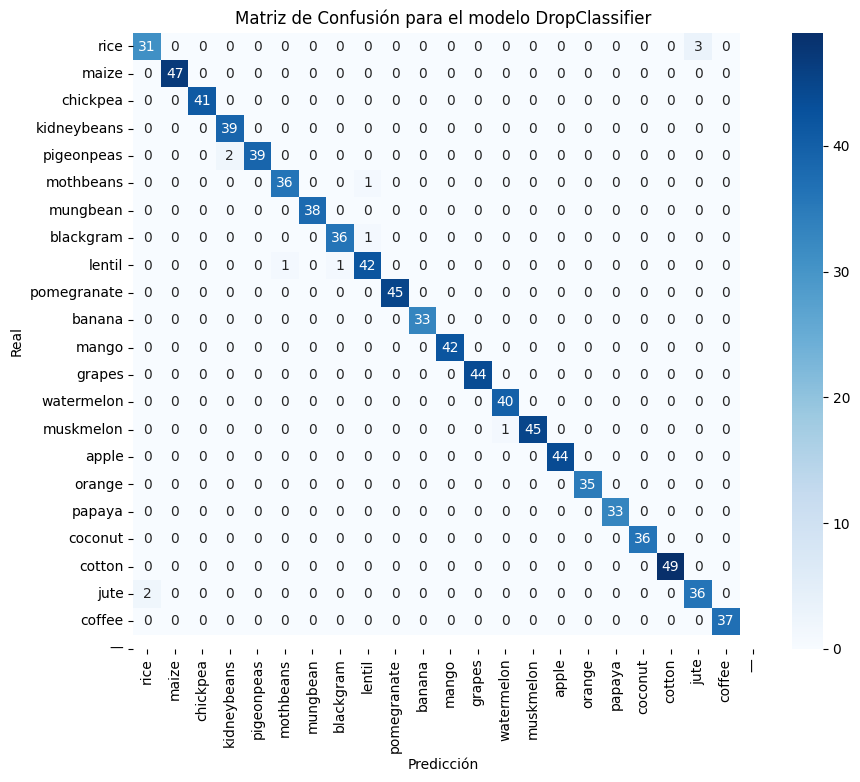


 Métricas para el modelo DeepDropoutClassifier:
+----------+-------------+--------------------+--------------------+--------------------+--------------------+
|          |   Cultivo   |     Precision      |       Recall       |      F1 Score      |      Accuracy      |
+----------+-------------+--------------------+--------------------+--------------------+--------------------+
|    0     |    rice     | 0.9655172413793104 | 0.8235294117647058 | 0.888888888888889  | 0.9920454545454546 |
|    1     |    maize    |        1.0         |        1.0         |        1.0         |        1.0         |
|    2     |  chickpea   |        1.0         |        1.0         |        1.0         |        1.0         |
|    3     | kidneybeans | 0.9285714285714286 |        1.0         | 0.962962962962963  | 0.9965909090909091 |
|    4     | pigeonpeas  |        1.0         | 0.926829268292683  | 0.9620253164556963 | 0.9965909090909091 |
|    5     |  mothbeans  |        1.0         | 0.9459459459459

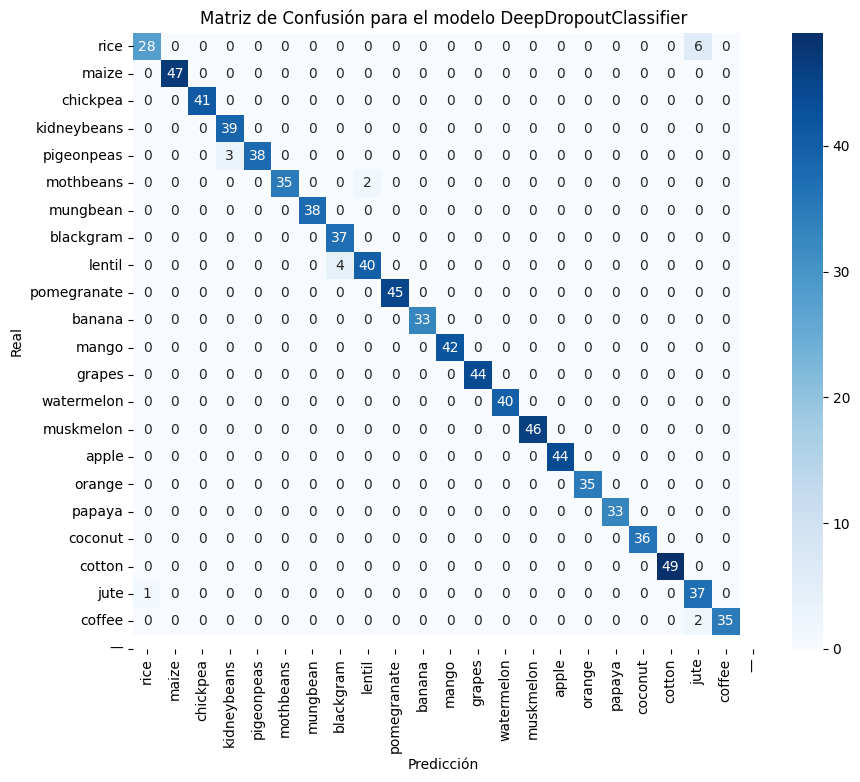

In [34]:
modelos = [
    (DropClassifier(dataset.num_classes), "DropClassifier"),
    (DeepDropoutClassifier(dataset.num_classes), "DeepDropoutClassifier")
]

# Configurar dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo utilizado: {device}")
# Entrenar múltiples modelos
train_multiple_models(modelos, train, val, device)